# PSTAT 134 Final Project: Analysis of The Yelp Dataset

## 1 Introduction

Yelp is a business directory service and crowd-sourced review forum. The company develops, hosts and markets the Yelp.com website and the Yelp mobile app, which publish crowd-sourced reviews about businesses. Yelp also provides an all-purpose open dataset for personal, educational, and academic purposes. It is a subset of Yelp’s data for businesses, reviews, users and more. The data is available as JSON files and in this project we used the business, review, and user datasets which include nearly 200,000 businesses, 6.5 million reviews, and 1.5 million users. This project will include exploratory analysis for the datasets, text classification, and image classification.

### 1.1 Preparing the Environment

In [1]:
# system
import json
import os
import cv2
import shutil
import imutils
from imutils import paths
import warnings
warnings.filterwarnings('ignore')
# basics
import numpy as np
import random
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime
# data visualization
import pydot
import pydotplus
import graphviz
from IPython.display import display
import seaborn as sns
# image processing
import matplotlib.image as mpimg
from PIL import Image
import pydot
%pylab inline
# modeling
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.utils.multiclass import unique_labels
# keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.utils import plot_model
from keras.utils import to_categorical
# nlp
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet as wn
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.decomposition import NMF, LatentDirichletAllocation

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
Using TensorFlow backend.


### 1.2 Downloading the Data

The very first step of any data science project is obtaining the data. In order to obtain the data that we would like to use, the dataset provided by Yelp for analysis purposes, we access the Kaggle API. The first step is to install the Kaggle API via terminal.

In [3]:
# install kaggle API
!pip install kaggle

Next, we make sure that the API access credentials are in the correct folder so that the system knows where to find them.

In [ ]:
# previously created kaggle API key in order to access datasets, yields kaggle.json
# make sure kaggle.json is in users/#name#/.kaggle

In [ ]:
# make API key not readable to other users
!chmod 600 /Users/#name#/.kaggle/kaggle.json

Now that we have accessed the API, we download the yelp dataset, direct it to the preferred path, and unzip the large files simultaneously.

In [5]:
# download and unzip the yelp-dataset kaggle files
!kaggle datasets download yelp-dataset/yelp-dataset -p /Users/candacemckeag/Documents/School/134 --unzip

100%|█████████████████████████████████████▉| 3.59G/3.59G [03:44<00:00, 19.2MB/s]
100%|██████████████████████████████████████| 3.59G/3.59G [03:44<00:00, 17.2MB/s]


Since the photos provided by Yelp are not accessible via the Kaggle API, they were manually downloaded via the Yelp dataset website.

In [2]:
!ls /Users/candacemckeag/Documents/School/134/textData
#contents of yelp dataset include 6 json files and 2 pdfs
#NOTE: additional files are to be made and added to this directory later

Dataset_Challenge_Dataset_Agreement.pdf yelp_academic_dataset_checkin.json
subset_business_over500.json            yelp_academic_dataset_review.json
subset_review.json                      yelp_academic_dataset_tip.json
yelp_academic_dataset_business.json     yelp_academic_dataset_user.json


### 1.3 Loading and Arranging the Data

We first look at the json file containing business data.

In [5]:
!head -n1 /Users/candacemckeag/Documents/School/134/textData/yelp_academic_dataset_business.json | jq .

{
  "business_id": "1SWheh84yJXfytovILXOAQ",
  "name": "Arizona Biltmore Golf Club",
  "address": "2818 E Camino Acequia Drive",
  "city": "Phoenix",
  "state": "AZ",
  "postal_code": "85016",
  "latitude": 33.5221425,
  "longitude": -112.0184807,
  "stars": 3,
  "review_count": 5,
  "is_open": 0,
  "attributes": {
    "GoodForKids": "False"
  },
  "categories": "Golf, Active Life",
  "hours": null
}


In [6]:
!wc -l /Users/candacemckeag/Documents/School/134/textData/yelp_academic_dataset_business.json
#number of business in data

  192609 /Users/candacemckeag/Documents/School/134/textData/yelp_academic_dataset_business.json


In [7]:
#jq -c to output by line
#select businesses with over 500 reviews
! jq -c 'select(.review_count>500)' /Users/candacemckeag/Documents/School/134/textData/yelp_academic_dataset_business.json > /Users/candacemckeag/Documents/School/134/textData/subset_business_over500.json

In [8]:
!wc -l /Users/candacemckeag/Documents/School/134/textData/subset_business_over500.json 
#number of businesses with more than 250 reviews

    1263 /Users/candacemckeag/Documents/School/134/textData/subset_business_over500.json


In [9]:
! jq -c 'select(.review_count<=500) and .review_count>250' /Users/candacemckeag/Documents/School/134/textData/yelp_academic_dataset_business.json | wc -l

  191346


There are too many businesses that have between 250 and 500 reviews, therefore it should be noted our analysis will consist of businesses with over 500 reviews. This is important because analysis of reviews for less "popular" businesses may be different from more popular businesses.

In [2]:
business = pd.read_json('/Users/candacemckeag/Documents/School/134/textData/subset_business_over500.json', lines = True)
business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,"1770 W Horizon Ridge, Ste 100","{'DriveThru': 'False', 'RestaurantsAttire': ''...",jScBTQtdAt-8RshaiBEHgw,"Ethnic Food, American (New), Burgers, Food, Re...",Henderson,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-15:0', '...",1,36.010745,-115.064803,Served,89012,664,4.5,NV
1,550 N Hayden Rd,"{'BusinessAcceptsCreditCards': 'True', 'Restau...",nsNONDHbV7Vudqh21uicqw,"Seafood, Restaurants",Scottsdale,"{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ...",1,33.454286,-111.909405,Salt Cellar,85257,526,3.5,AZ
2,3655 Las Vegas Blvd S,"{'RestaurantsTakeOut': 'True', 'RestaurantsDel...",6fPQJq4f_yiq1NHn0fd11Q,"French, Restaurants, Creperies",Las Vegas,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,36.112527,-115.171351,La Creperie,89109,535,3.5,NV
3,1008 E Camelback Rd,"{'Alcohol': 'u'full_bar'', 'RestaurantsAttire'...",dUffgo9Lh_Vk9TLuFR5ywg,"Restaurants, Pizza, Sandwiches, Italian",Phoenix,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",1,33.509510,-112.060238,Oregano's Pizza Bistro,85014,563,3.5,AZ
4,3131 Las Vegas Blvd S,"{'BusinessParking': '{'garage': True, 'street'...",_pBXtjN43eqMV0XZTz7nmw,"Music Venues, Dance Clubs, Arts & Entertainmen...",Las Vegas,"{'Wednesday': '22:30-4:0', 'Friday': '22:30-4:...",0,36.129243,-115.165644,Encore Beach Club at Night,89109,865,3.5,NV


In [3]:
business.tail()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
1258,"9915 W McDowell Rd, Ste 104","{'RestaurantsGoodForGroups': 'True', 'Restaura...",KOEBBp2PhiV_4PkW9eo9Sg,"Greek, Restaurants, Middle Eastern, Mediterran...",Avondale,"{'Monday': '0:0-0:0', 'Tuesday': '10:30-18:0',...",1,33.464143,-112.273057,Pita Kitchen - Avondale,85392,569,4.5,AZ
1259,7070 N Durango Dr,"{'NoiseLevel': 'u'average'', 'OutdoorSeating':...",qRymrsLmlA34bC8PvNoujg,"Mediterranean, Caterers, Event Planning & Serv...",Las Vegas,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",1,36.289201,-115.287334,Market Grille Cafe,89149,572,4.0,NV
1260,3240 S Arville St,"{'BusinessParking': '{'garage': False, 'street...",P8uECqGqXWTwEndkh-6bQw,"Sandwiches, Pizza, Chicken Wings, Italian, Res...",Las Vegas,"{'Monday': '12:0-21:0', 'Tuesday': '12:0-21:0'...",1,36.130804,-115.198971,Naked City Pizza Shop,89102,576,4.0,NV
1261,"8975 S Eastern Ave, Ste 3C","{'Alcohol': 'u'none'', 'BusinessParking': '{'g...",p5rpYtxS5xPQjt3MXYVEwA,"Sandwiches, Cafes, Pizza, Vegetarian, Gluten-F...",Las Vegas,"{'Monday': '9:30-19:30', 'Tuesday': '7:0-22:0'...",1,36.026212,-115.119341,Greens and Proteins,89123,704,4.0,NV
1262,5611 S Valley View Blvd,"{'Caters': 'True', 'RestaurantsTableService': ...",ngs16C2M_uTq2zXamltHVw,"Farmers Market, Caterers, Food, Street Vendors...",Las Vegas,"{'Monday': '0:0-0:0', 'Tuesday': '11:30-20:30'...",1,36.087895,-115.190329,Jessie Rae's BBQ,89118,595,4.5,NV


In [5]:
business['review_count'].sum()

1234870

In [4]:
biz_id = business['business_id'].values

In [7]:
len(biz_id)

1263

There are over 1 million reviews for these businesses, once again due to computer limitations we will take a subset of the data. We will randomly select 50 reviews for each business.

In [15]:
!head -n1 /Users/candacemckeag/Documents/School/134/textData/yelp_academic_dataset_review.json | jq .

{
  "review_id": "Q1sbwvVQXV2734tPgoKj4Q",
  "user_id": "hG7b0MtEbXx5QzbzE6C_VA",
  "business_id": "ujmEBvifdJM6h6RLv4wQIg",
  "stars": 1,
  "useful": 6,
  "funny": 1,
  "cool": 0,
  "text": "Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.",
  "date": "2013-05-07 04:34:36"
}


In [ ]:
!touch /Users/candacemckeag/Documents/School/134/textData/subset_review.json #create empty file in case notebook needs to run again
for b in biz_id:
    !grep -- $b /Users/candacemckeag/Documents/School/134/textData/yelp_academic_dataset_review.json | shuf -n 50 >> /Users/candacemckeag/Documents/School/134/textData/subset_review.json
    #grep mathces unique business_id to reviews then randomly selects 50 reviews and appends to file
    #jq -c might have worked as well but just in case grep was used for input for shuf
    #shuf randomly selects 50 reviews that matched the business_id
    #since >> appends to file it is important to use the first line in this cell to create a new empty file or you will add on to existing lines if you run this cell multiple times

^C


In [1]:
!wc -l /Users/candacemckeag/Documents/School/134/textData/subset_review.json 
#double check it worked 
#expect output sample number times number of businesses, e.g.
#if 1263 businesses and random sample 50 reviews then expect 63150 lines

   63150 /Users/candacemckeag/Documents/School/134/textData/subset_review.json


In [5]:
reviews = pd.read_json('/Users/candacemckeag/Documents/School/134/textData/subset_review.json', lines = True)

In [9]:
reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,jScBTQtdAt-8RshaiBEHgw,0,2016-06-21 20:54:28,0,1jKn3mgSamCvmAPYRwRsew,3,First time here and i would like to say the pl...,1,WXA_4WVO1tpD0So3pZOQQQ
1,jScBTQtdAt-8RshaiBEHgw,3,2016-07-02 18:37:12,1,rtGw_i8FcpwIRNS1OWmuHA,5,I hope that this place makes it because everyt...,3,bgn06l4XfW9P_-TgLPS3tw
2,jScBTQtdAt-8RshaiBEHgw,1,2018-01-11 02:42:38,0,S0R9z62w4Rzc741reFNBmg,4,I had the miso pork belly burger and the thing...,1,hJnqE_-Ijr55MFkbc1YghQ
3,jScBTQtdAt-8RshaiBEHgw,2,2017-10-20 01:14:01,0,Ot5kLJ3TDk0YXZ1FBaoESg,5,Delicious food with very friendly and accommod...,3,fMSmWCg5ge5pxVlbCgjtxQ
4,jScBTQtdAt-8RshaiBEHgw,1,2018-03-07 22:42:02,1,-FVXDl7uUeIiHuk5Jql8aQ,5,This place is definitely worth the search. Loc...,1,Gn_06I6jbXgKtc64SEuIVw


In [10]:
reviews.tail()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
63145,ngs16C2M_uTq2zXamltHVw,0,2016-05-27 16:33:00,0,USWSsUDtvT8GwRKMXoHr5A,5,Hole in the wall smokey bbq. Came here for lun...,1,V26EHxCEXhJ0Ziv3GR-Vkg
63146,ngs16C2M_uTq2zXamltHVw,0,2017-12-28 15:28:30,0,8cw87kKbFh2hPTzWpM-ULw,5,"OMG!! The absolute BEST barbeque in Vegas, he...",0,njkK2DuI-Zy2yq_Vs6O93A
63147,ngs16C2M_uTq2zXamltHVw,0,2017-12-29 20:59:09,0,_1rL2pFzuxrqJBkR9lj5Ow,5,A lot of people will not like this place becau...,0,J18ol0RI1TuyqGKFZJfh3w
63148,ngs16C2M_uTq2zXamltHVw,0,2018-02-19 22:10:33,0,72mCdUwWxvp2qhVQukbYfg,5,Awesome spot. The maniac fries are unreal. Add...,0,sONa3N__KYh74Ylyqz5FpQ
63149,ngs16C2M_uTq2zXamltHVw,0,2017-04-17 20:47:50,0,5z84GTLA0X-n3-i2gdyhmg,1,Just stopped by this place and had the ribs an...,1,IjY4cxh6epnx-Q4aIaHSfQ


In [12]:
reviews['user_id'].nunique()

53753

Interesting to see what user attributes may influence reviews and creating networks from the friends list may also be an interesting analysis


In [14]:
!head -n1 /Users/candacemckeag/Documents/School/134/textData/yelp_academic_dataset_user.json | jq .

{
  "user_id": "l6BmjZMeQD3rDxWUbiAiow",
  "name": "Rashmi",
  "review_count": 95,
  "yelping_since": "2013-10-08 23:11:33",
  "useful": 84,
  "funny": 17,
  "cool": 25,
  "elite": "2015,2016,2017",
  "friends": "c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g, ajcnq75Z5xxkvUSmmJ1bCg, BSMAmp2-wMzCkhTfq9ToNg, jka10dk9ygX76hJG0gfPZQ, dut0e4xvme7QSlesOycHQA, l4l5lBnK356zBua7B-UJ6Q, 0HicMOOs-M_gl2eO-zES4Q, _uI57wL2fLyftrcSFpfSGQ, T4_Qd0YWbC3co6WSMw4vxg, iBRoLWPtWmsI1kdbE9ORSA, xjrUcid6Ymq0DoTJELkYyw, GqadWVzJ6At-vgLzK_SKgA, DvB13VJBmSnbFXBVBsKmDA, vRP9nQkYTeNioDjtxZlVhg, gT0A1iN3eeQ8EMAjJhwQtw, 6yCWjFPtp_AD4x93WAwmnw, 1dKzpNnib-JlViKv8_Gt5g, 3Bv4_JxHXq-gVLOxYMQX0Q, ikQyfu1iViYh8T0us7wiFQ, f1GGltNaB7K5DR1jf3dOmg, tgeFUChlh7v8bZFVl2-hjQ, -9-9oyXlqsMG2he5xIWdLQ, Adj9fBPVJad8vSs-mIP7gw, Ce49RY8CKXVsTifxRYFTsw, M1_7TLi8CbdA89nFLlH4iw, wFsNv-hqbW_F5-IRqfBN6g, 0Q1L7zXHocaUZ2gsG2XJeg, cBFgmOCBdhYa0xoFEAzp_g, VrD_AgiFvzqtlR15vir3SQ, cpE-7HK514Sr5vpSen9CEQ, F1UYelhPFB-zIKlt0ygIZg, CQAL1hvsLMCzuJf9Agl

## 2 Exploratory Data Analysis

### 2.1 User Data

In [6]:
with open('textData/yelp_academic_dataset_user.json') as json_file:      
    data = json_file.readlines()
    # this line below may take at least 8-10 minutes of processing for 4-5 million rows. It converts all strings in list to actual json objects. 
    data = list(map(json.loads, data)) 

yelp_user = pd.DataFrame(data)

In [7]:
yelp_user['yelping_since'] = yelp_user['yelping_since'].apply(lambda x: str(x)[:10])

In [10]:
acct_created_perdate = yelp_user.groupby('yelping_since').size()

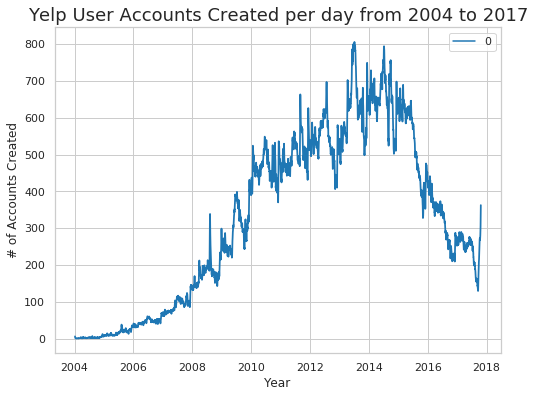

In [42]:
values = acct_created_perdate.tolist()
dates = pd.date_range('1 1 2004', periods = 5043, freq = 'D')

data = pd.DataFrame(values, dates)
data = data.rolling(7).mean()

fig = plt.figure(figsize=(8,6))
sns.set(style = 'whitegrid')
sns.lineplot(data=data, palette = 'tab10', linewidth = 1.75)
plt.title('Yelp User Accounts Created per day from 2004 to 2017',fontsize = 18)
plt.xlabel('Year')
plt.ylabel('# of Accounts Created')
plt.show()

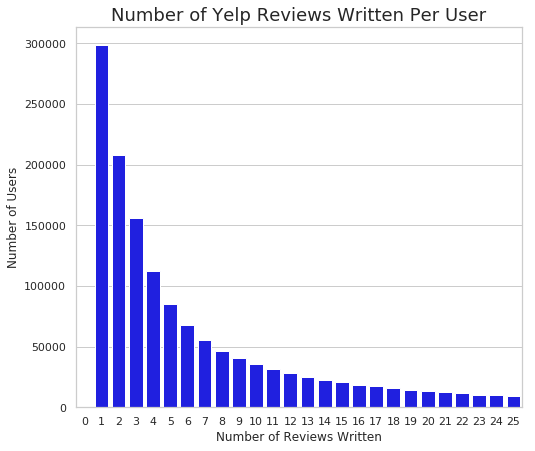

In [43]:
plt.figure(figsize=(8, 7))
sns.set(style = 'whitegrid')

review_df = pd.DataFrame(list(yelp_user.groupby(['review_count']).size())[0:50],list(range(50)))
ax = sns.barplot(x = list(range(26)), y = list(yelp_user.groupby(['review_count']).size())[0:26], color = 'blue')
plt.title('Number of Yelp Reviews Written Per User', fontsize = 18)
plt.xlabel('Number of Reviews Written')
plt.ylabel('Number of Users')
plt.show()

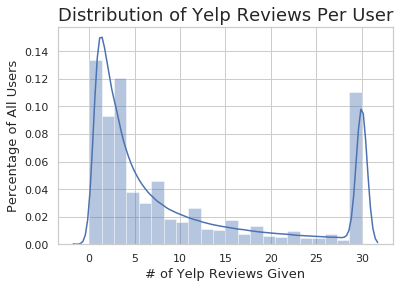

In [44]:
temp_user_review_count = list(yelp_user['review_count'])
counter = 0
max_30 = []
for i in temp_user_review_count:
    if i > 30:
        max_30.append(30)
    else:
        max_30.append(i)
        
ax = sns.distplot(max_30, bins = 22)
#ax.set(xticks = [0,5,10,15,20,25,30])
#plt.xlim((0, 30))
plt.title('Distribution of Yelp Reviews Per User', fontsize = 18)
plt.xlabel('# of Yelp Reviews Given', fontsize = 13)
plt.ylabel('Percentage of All Users', fontsize = 13)
plt.show()

### 2.2 Business Data

In [18]:
np.sort(business['stars'].unique())

array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [20]:
np.sort(reviews['stars'].unique())

array([1, 2, 3, 4, 5])

Since our dataset consists of businesses and reviews from businesses which have over 500 reviews, we can deduce that these businesses are fairly "popular" and would suggest that they should have good ratings. In the plot below we can see that most businesses, nearly half of our dataset, are rated 4.0 stars.

In the plot containing number of reviews for each rating, we see that most reviews are either 4.0 or 5.0 stars. Once again, this agrees with our assumption that number of reviews and ratings have a cooperative effect, meaning a more popular business probably has better reviews and a business with good reviews is probably more popular. We shall investigate this further in the plots below. It should be noted, as in the beginning of this notebook, that our business dataset is the entire population of businesses with over 500 reviews from the original dataset but we randomly sampled 50 reviews for each business from the original review dataset.

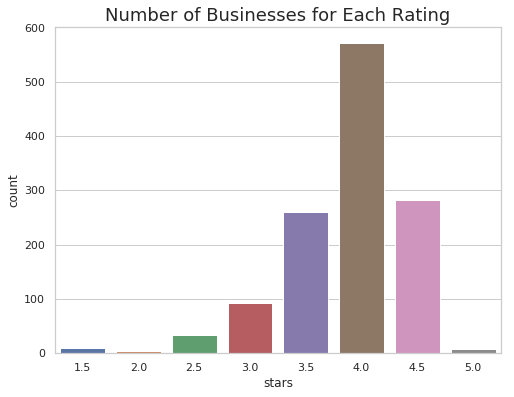

In [45]:
fig = plt.figure(figsize=(8,6))
sns.set(style = 'whitegrid')
sns.countplot(business['stars']).set_title('Number of Businesses for Each Rating',fontsize = 18)

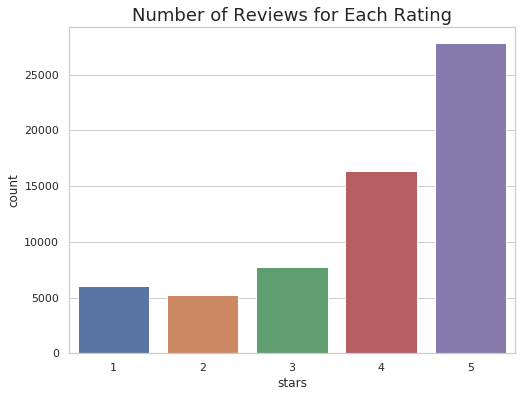

In [46]:
fig = plt.figure(figsize=(8,6))
sns.countplot(reviews['stars']).set_title('Number of Reviews for Each Rating',fontsize = 18)

In the plots below we examine the distribution of the amount of reviews for each business in the dataset. We see that roughly half of the businesses in our dataset have between 585 and 1051 reviews. However, about 150 businesses in the dataset could be considered outliers past the third quartile using the traditional method of Q3 + IQR. In our case Q3 + IQR = 1518 reviews so outliers in this dataset are businesses with over 1518 reviews.

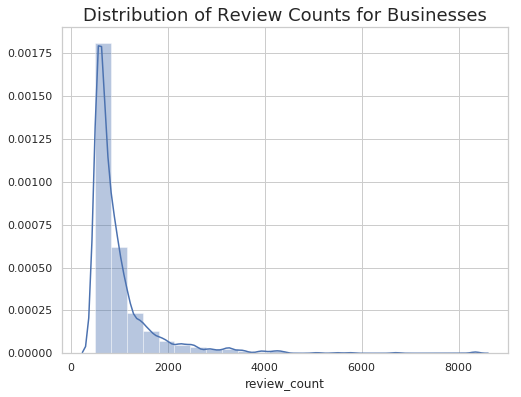

In [22]:
fig = plt.figure(figsize=(8,6))
sns.distplot(business['review_count'], bins = 24).set_title('Distribution of Review Counts for Businesses',fontsize = 18)

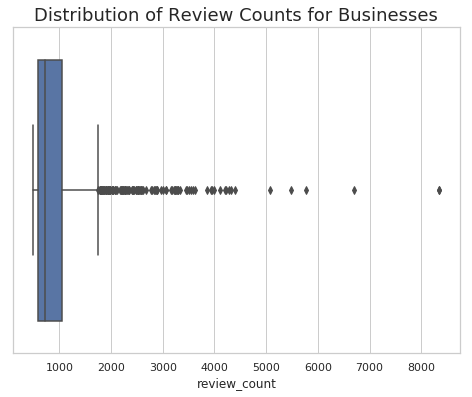

In [23]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(business['review_count']).set_title('Distribution of Review Counts for Businesses',fontsize = 18)

In [27]:
business['review_count'].describe()

count    1263.000000
mean      977.727633
std       726.569427
min       501.000000
25%       585.000000
50%       726.000000
75%      1051.500000
max      8348.000000
Name: review_count, dtype: float64

In [28]:
IQR = 1051.5 - 585
1051.5 + IQR

1518.0

In [29]:
len(business[business['review_count'] > 1518])

150


In the figures below we see the distribtution of review counts for businesses at each rating level. In the first plot we used a traditional boxplot and the second is a boxenplot to show the many quantiles. Surprisingly, we can see that while there are fewer businesses with 2.5 stars, these businesses actually have a lot of reviews (almost the top 40% has over 1000 reviews) suggesting they are popular. There could be many reasons for this, one possible explanation is that these businesses are famous for other reasons than the quality of their service such as a celebrity owner/endorser or being in a landmark location.

Furthermore, we can see that businesses with 5.0, 2.0, and 1.5 star ratings are the least varied and most of these businesses have less than 1000 reviews. There are several explanations for this. One explanation is that there are very few businesses with low ratings and over 500 reviews because most consumers would not continue to go to businesses with low ratings and poor reviews. On the other hand, for the businesses with 5.0 stars, it could be the fact that since these businesses are not as popular it could be easier to achieve such a rating with quality service. An interesting analysis would be to check how long a business can sustain or "survive" at 5 stars until it drops down to a more modest 4.0 or 4.5 stars. Since review dates are available this could be in a future analysis.

Lastly, since the most popular ratings are 4.0, 4.5, and 3.5 respectively, we see that the distribution of review counts for these businesses are the most varied. This is again not very surprising since most businesses in our dataset have these ratings and these ratings are fairly "modest".

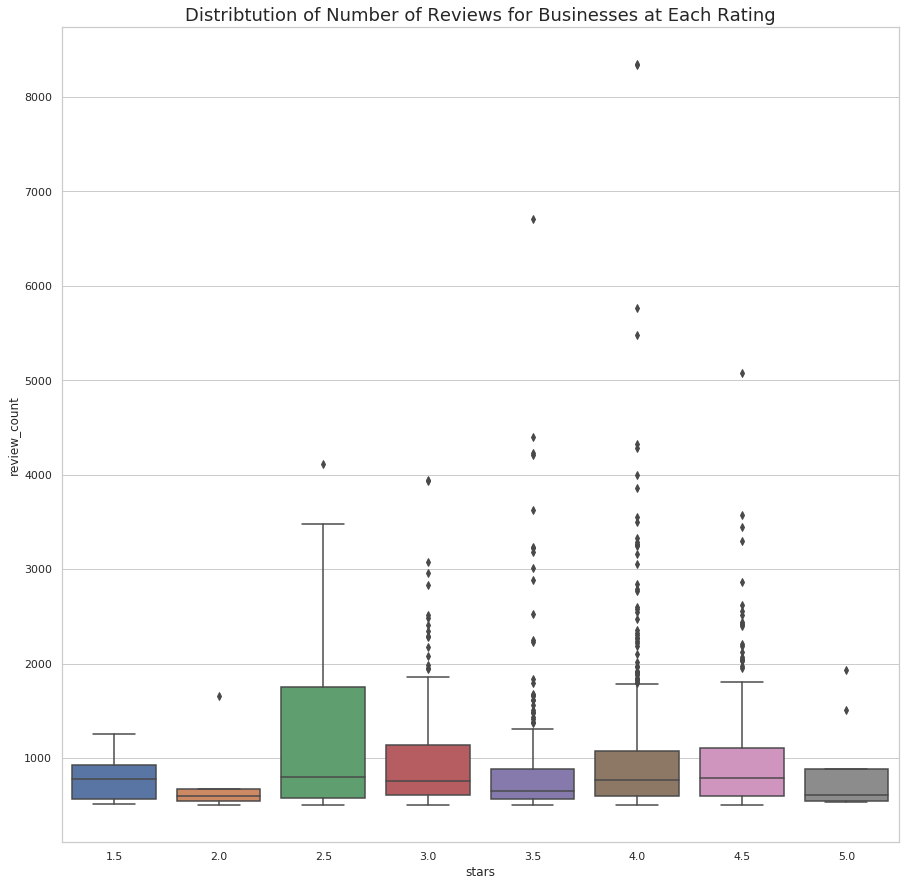

In [24]:
fig = plt.figure(figsize=(15,15))
sns.boxplot(x = 'stars', y = 'review_count', data = business).set_title('Distribtution of Number of Reviews for Businesses at Each Rating', fontsize = 18)

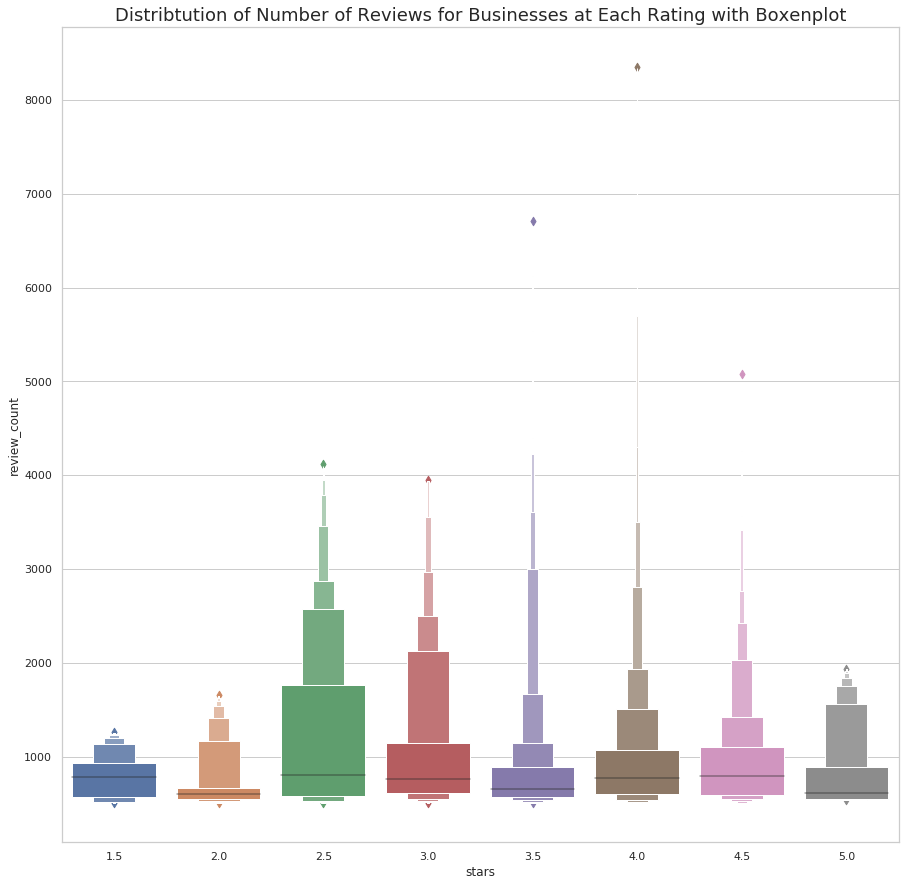

In [25]:
fig = plt.figure(figsize=(15,15))
sns.boxenplot(x = 'stars', y = 'review_count', data = business).set_title('Distribtution of Number of Reviews for Businesses at Each Rating with Boxenplot', fontsize = 18)

In [32]:
business['state'].unique()

array(['NV', 'AZ', 'PA', 'WI', 'OH', 'ON', 'NC', 'QC', 'TX', 'FL', 'IL'],
      dtype=object)

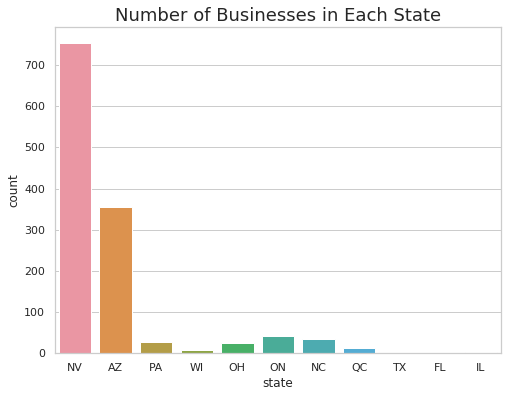

In [26]:
fig = plt.figure(figsize=(8,6))
sns.set(style = 'whitegrid')
sns.countplot(business['state']).set_title('Number of Businesses in Each State',fontsize = 18)

In [34]:
business[business['state'] == 'NV']['city'].unique()

array(['Henderson', 'Las Vegas', 'Spring Valley', 'North Las Vegas',
       'Boulder City', 'Summerlin'], dtype=object)

In [35]:
business[business['state'] == 'AZ']['city'].unique()

array(['Scottsdale', 'Phoenix', 'Glendale', 'Tempe', 'Chandler',
       'Gilbert', 'Litchfield Park', 'Goodyear', 'Mesa', 'Cave Creek',
       'Paradise Valley', 'Surprise', 'Avondale', 'Peoria'], dtype=object)

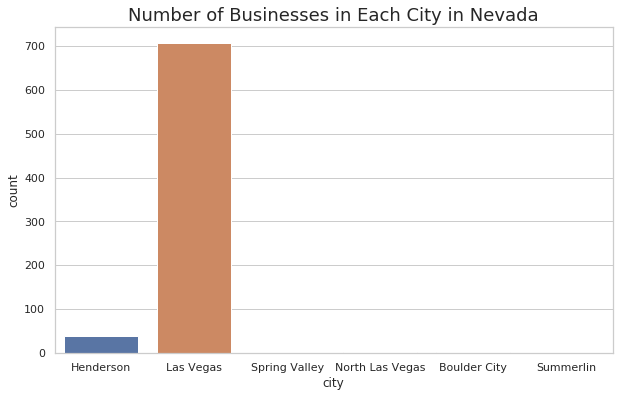

In [27]:
fig = plt.figure(figsize=(10,6))
sns.set(style = 'whitegrid')
sns.countplot(business[business['state'] == 'NV']['city']).set_title('Number of Businesses in Each City in Nevada',fontsize = 18)

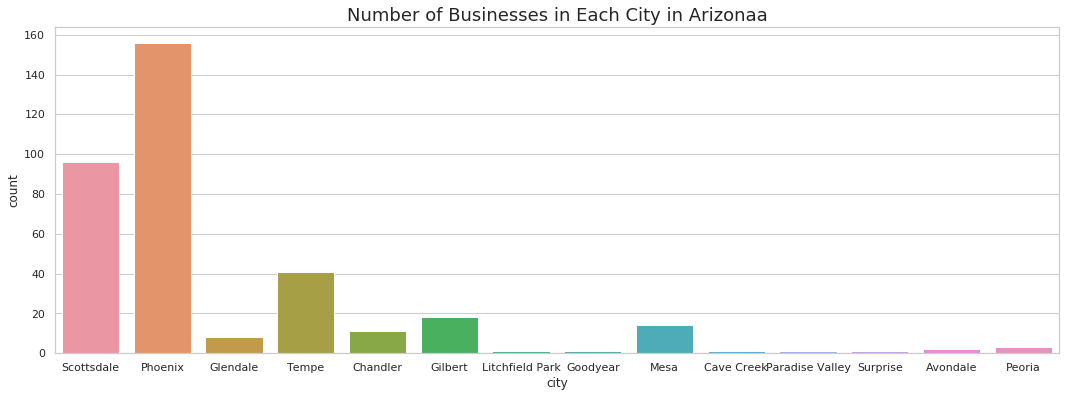

In [28]:
fig = plt.figure(figsize=(18,6))
sns.set(style = 'whitegrid')
sns.countplot(business[business['state'] == 'AZ']['city']).set_title('Number of Businesses in Each City in Arizonaa',fontsize = 18)

## 3 Text Analysis

### 3.1 Exploratory Wordclouds

Wordclouds for reviews at each rating {1,2,3,4,5} without text normalization

In the one and two star reviews, you can see words such "worst", "horrible", "mediocre", "overpriced", and "bad" as expected. Although, you see some positive words as well such as "great" or "good" which may suggest to use NGram models to get more context when modeling. In the higher star reviews we mostly see words such as "amazing" or "awesome" which is a good indicator of what types of words may be predictive of high reviews.

In [40]:
def show_wordcloud(data, title = None): #function to show word cloud copied from stackoverflow
    wordcloud = WordCloud(
        background_color='white',
        width = 200,
        height = 100,
        max_words=20,
        max_font_size=40,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

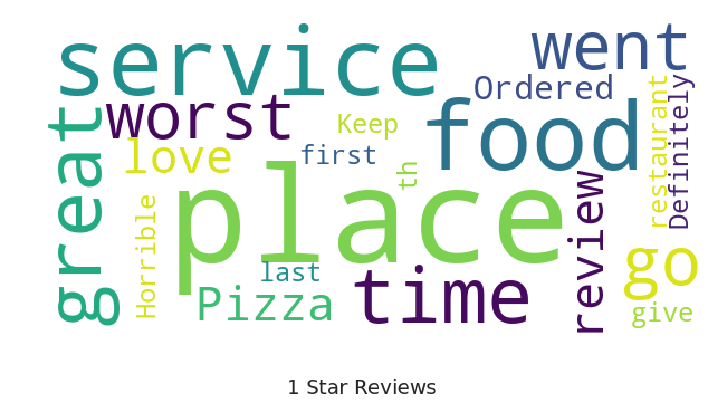

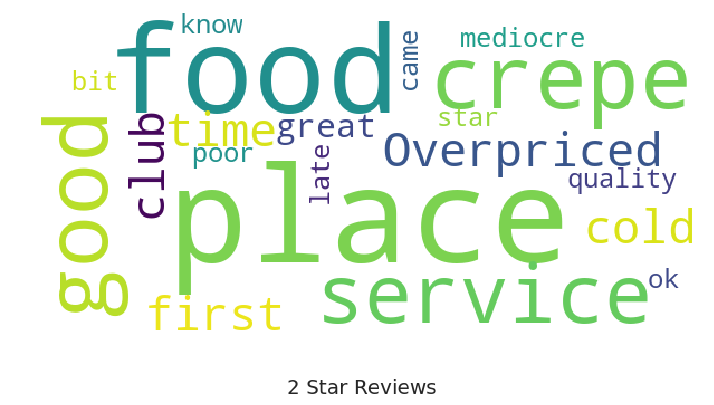

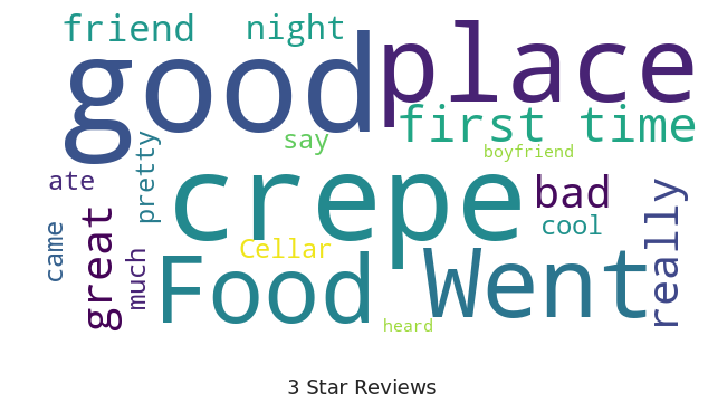

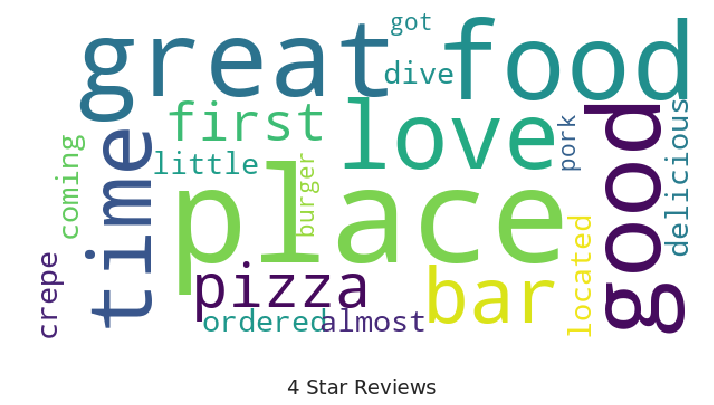

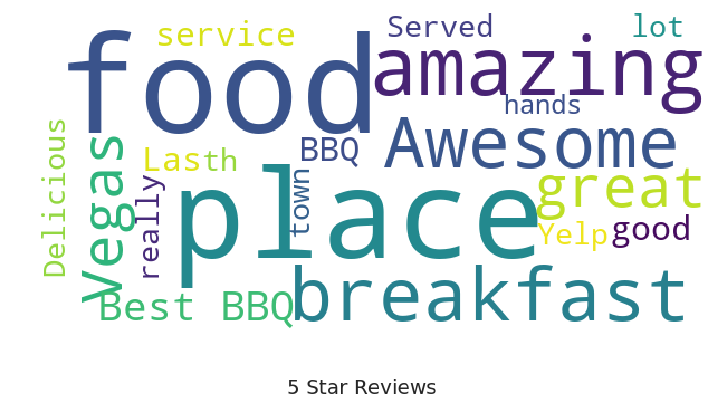

In [41]:
for s in [1,2,3,4,5]:
    show_wordcloud(reviews[reviews['stars'] == s]['text'], title = str(s) + " Star Reviews")

## 3.2 Modeling

* TfidiVectorizer does text normalization e.g. strips special characters, lowercase strings, remove stopwords, and computes tfidf values all in one step, e.g. term frequency, doc frequency and idf values

* Multiclassclassification, stars (classes): 1,2,3,4,5

* Model Selection: -Begin with unigram tfidf values -Try NGram -Include other features: sentiment scores, funny, cool, useful -Use Cross-Validation for parameter selection and model tuning -Evaluate on validation set -Class weight = 'balanced' to address class imbalance (most reviewes are 5's) -Algorithms:

  1. Naive Bayes (Gaussian, Multinomial)
  2. Logistic Regression
  3. Support Vector Machine


### 3.2.1 Sentiment Analysis

In [40]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/candacemckeag/nltk_data...


In [42]:
sentScores = reviews['text'].map(lambda row: sid.polarity_scores(row)).apply(pd.Series)

In [43]:
sentScores.head()

,neg,neu,pos,compound
0,0.038,0.818,0.144,0.9391
1,0.000,0.897,0.103,0.7067
2,0.000,0.802,0.198,0.8966
3,0.016,0.745,0.239,0.9952
4,0.065,0.641,0.294,0.9125


In [44]:
sentScores.tail()

,neg,neu,pos,compound
63145,0.045,0.748,0.207,0.9602
63146,0.113,0.591,0.296,0.9586
63147,0.080,0.816,0.104,0.3138
63148,0.063,0.622,0.315,0.9639
63149,0.119,0.849,0.032,-0.6521


In [45]:
reviews = pd.concat([reviews, sentScores], axis = 1)

In [46]:
reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,neg,neu,pos,compound
0,jScBTQtdAt-8RshaiBEHgw,0,2016-06-21 20:54:28,0,1jKn3mgSamCvmAPYRwRsew,3,First time here and i would like to say the pl...,1,WXA_4WVO1tpD0So3pZOQQQ,0.038,0.818,0.144,0.9391
1,jScBTQtdAt-8RshaiBEHgw,3,2016-07-02 18:37:12,1,rtGw_i8FcpwIRNS1OWmuHA,5,I hope that this place makes it because everyt...,3,bgn06l4XfW9P_-TgLPS3tw,0.000,0.897,0.103,0.7067
2,jScBTQtdAt-8RshaiBEHgw,1,2018-01-11 02:42:38,0,S0R9z62w4Rzc741reFNBmg,4,I had the miso pork belly burger and the thing...,1,hJnqE_-Ijr55MFkbc1YghQ,0.000,0.802,0.198,0.8966
3,jScBTQtdAt-8RshaiBEHgw,2,2017-10-20 01:14:01,0,Ot5kLJ3TDk0YXZ1FBaoESg,5,Delicious food with very friendly and accommod...,3,fMSmWCg5ge5pxVlbCgjtxQ,0.016,0.745,0.239,0.9952
4,jScBTQtdAt-8RshaiBEHgw,1,2018-03-07 22:42:02,1,-FVXDl7uUeIiHuk5Jql8aQ,5,This place is definitely worth the search. Loc...,1,Gn_06I6jbXgKtc64SEuIVw,0.065,0.641,0.294,0.9125


### 3.2.2 Logistic Regression Model

In [49]:
tfidf_vec = TfidfVectorizer(max_df = 0.90, min_df = 20, stop_words = 'english', strip_accents = 'ascii', lowercase = True)
TFIDF_df = tfidf_vec.fit_transform(reviews['text'])
TFIDF_df = pd.DataFrame(TFIDF_df.toarray(), columns = tfidf_vec.get_feature_names())

In [50]:
X_Train_tfidf, X_Test_tfidf, Y_Train_tfidf, Y_Test_tfidf = train_test_split(TFIDF_df, reviews['stars'], test_size = 0.2, random_state = 69)

In [51]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize = False, title = None, cmap = plt.cm.Blues):
    
    cm = metrics.confusion_matrix(y_true, y_pred)

    
    print('Confusion Matrix')
    print(cm)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots(figsize = (12,12))
    im = ax.imshow(cm, interpolation = 'nearest', cmap = cmap)
    ax.figure.colorbar(im, ax = ax)
    
    ax.set(xticks = np.arange(cm.shape[1]),
           yticks = np.arange(cm.shape[0]),
           xticklabels = classes, yticklabels = classes,
           title = title,
           ylabel = 'True label',
           xlabel = 'Predicted label')
    
     # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

In [52]:
def log_reg(X_Train, Y_Train, X_Test, Y_Test, scale = False, weight = False):
      
    if weight:
        logReg = LogisticRegression(class_weight='balanced')
    else:
        logReg = LogisticRegression()
        
    param_grid = [{'penalty': ['l2'], 'C': np.linspace(0.1,1,10)}]
    
    if scale:
        scaler = StandardScaler()
        scaler.fit(X_Train)
        X_Train = scaler.transform(X_Train)
        scaler.fit(X_Test)
        X_Test = scaler.transform(X_Test)

    
    
    clf = GridSearchCV(logReg, param_grid, cv = 5)
    clf.fit(X_Train, Y_Train)
    
     
    predictions = clf.predict(X_Test)
    
    
    acc = [metrics.accuracy_score(Y_Test, predictions)]
    rec = [metrics.recall_score(Y_Test, predictions, labels = [1,2,3,4,5], average = 'macro')]
    prec = [metrics.precision_score(Y_Test, predictions, labels = [1,2,3,4,5], average = 'macro')]

    plot_confusion_matrix(Y_Test, predictions, classes = [1,2,3,4,5],normalize = True, title = 'Normalized Logistic Regression Confusion Matrix')
    

    print(clf.best_params_)
    data = {'Accuracy': acc, 'Recall': rec, 'Precision': prec}
    df = pd.DataFrame(data)
    
    return df

Confusion Matrix
[[ 857  128   76   73   84]
 [ 238  217  243  157  128]
 [ 104  133  480  568  288]
 [  32   17  156 1399 1670]
 [  25    3   32  650 4872]]
{'C': 1.0, 'penalty': 'l2'}


,Accuracy,Recall,Precision
0,0.619557,0.505925,0.557527


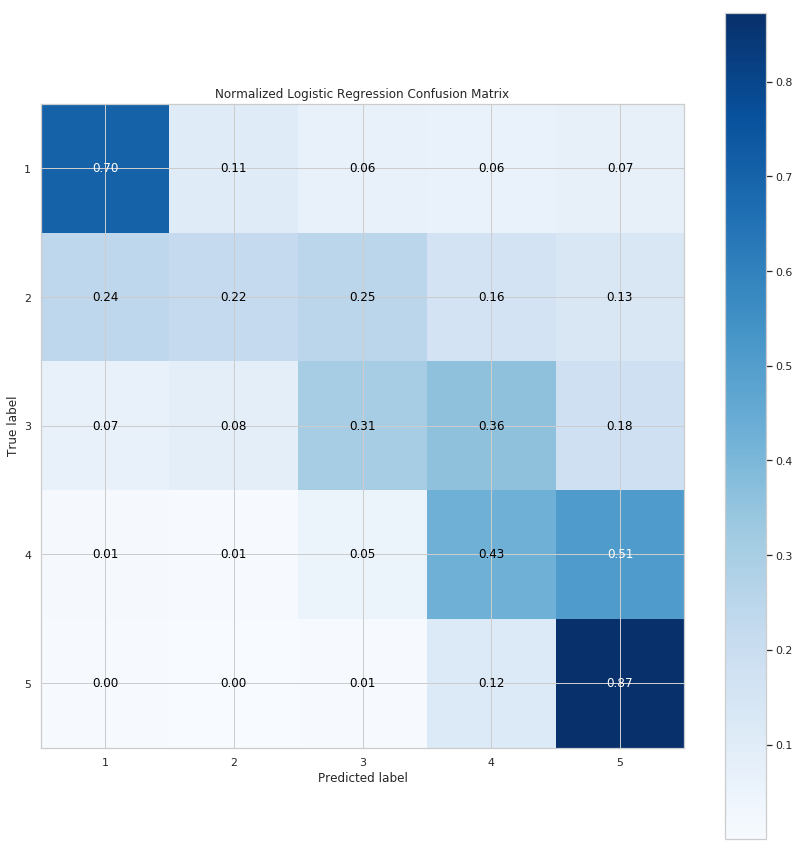

In [53]:
log_reg(X_Train_tfidf, Y_Train_tfidf, X_Test_tfidf, Y_Test_tfidf, scale = False, weight = False)

### 3.2.3 Topic Modeling

In [53]:
tfidf_vec = TfidfVectorizer(max_df = 0.95, min_df = 10, stop_words = 'english')
tfidf = tfidf_vec.fit_transform(reviews['text'])
tfidf_feat_names = tfidf_vec.get_feature_names()

tf_vec = CountVectorizer(max_df = 0.95, min_df = 10, stop_words = "english")
tf = tf_vec.fit_transform(reviews['text'])
tf_feat_names = tf_vec.get_feature_names()

In [58]:
nmf = NMF(n_components= 20).fit(tfidf)
lda = LatentDirichletAllocation(n_topics= 20).fit(tf)

In [59]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topics: ", topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words  - 1:-1]]))

print('NMF')
display_topics(nmf, tfidf_feat_names, 20)
print('\n\nLDA')
display_topics(lda, tf_feat_names, 20)

NMF
Topics:  0
time just minutes order table got wait didn came like said don asked took people did told went server long
Topics:  1
great atmosphere service awesome beer selection drinks time experience fun spot music loved fantastic location bar server night job definitely
Topics:  2
room hotel stay rooms pool nice strip casino stayed clean desk floor check view night bed bathroom resort like hotels
Topics:  3
place recommend try like eat awesome definitely cool looking fun nice just friends highly want really don people small area
Topics:  4
pizza crust cheese slice pepperoni pizzas salad garlic sauce chicago slices sausage italian style toppings deep oven wings ny pasta
Topics:  5
good really pretty nice beer little selection price overall prices bit atmosphere like decent liked lot got just wasn enjoyed
Topics:  6
sushi rolls roll fresh fish ayce eat quality tuna sashimi rice nigiri salmon japanese favorite places price tempura chefs service
Topics:  7
ordered salad steak restaura

## 4 Convolutional Neural Network Image Classification

This part of the project consists of building a convolutional neural network that is able to classify the contents of an image as either the **outside of a business** or **food** using photos provided by the Yelp dataset. We have 1,172 images of food and 1,001 images of the outside of businesses.

  <tr>
    <td> <img src="projdata/train/food/OvyQG_yKe-GEXgX7l5_E4A.jpg"  style="width: 250px;"/> </td>
    <td> <img src="projdata/train/outside/fLmjhrhcpTNRAgXJYf5sPA.jpg" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="projdata/train/food/TVJeFR790-y5IfZ6v4i27w.jpg" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="projdata/train/outside/0yWyHteR5U7hOBoYpm23kg.jpg" alt="Drawing" style="width: 250px;"/> </td>
    </tr>

### 4.1 Introduction and Purpose

We now build an image classification model using the Keras API. Keras is a high-level neural networks and deep learning library available in Python. Since neural networks are a very in-depth and complicated concept, we try to err on the side of caution and ensure that we understand every function and idea that we implement in the network.

As a broad and simple overview of neural networks, it is composed of layers of artifical neurons which receive input, alter their function according to that input, then produce output depending on that input and alterations. This output is connected to the input of another neuron. Based on the alterations the neurons make and the weights created by the inputs, the network can learn from previous observations. This involves the incorporation of a cost function which measures how far away a particular solution is from an optimal solutio. The goal is then to find the function which minimizes that cost.

Deep neural networks have multiple layers between the input and output layers. Convolutional neural networks are a class of fully-connected, deep neural networks. This means that each neuron in one layer is connected to all neurons in the next layer. CNNs avoid overfitting by using regularization methods such as adding weights to the loss function. CNNs are on the lower extreme on the scale of connectedness and complexity and are most commonly applied to analyzing visual imagery.

The purpose of building a network that is able to tell you what is in an image it is given may not be obvious. However, image classification is becoming increasingly common and utilized by many companies. Facebook uses facial recognition to see who is in a photo to suggest tags, the healthcare industry uses computer visison to perform microsurgical procedures, and the retail industry uses image recognition to compare quality and prices of different products. Though this particular image classification project is quite simple relative to other networks, it is a first step in exposure to the complex field of neural networks. An image classification program is of great use to many industries, and a fascinating part of data science.

### 4.2 Data Augmentation

In order to make the most of the training examples and provide the model with as much predictive power as possible, we "augment" them by using random transformations. This ensures that the model never sees the exact same picture twice and also helps prevent overfitting by improving generalizability. We want our network to be invariant, meaning it can robustly classify objects even if they are placed in different orientations. The function used generates batches of tensor image data with real-time data augmentation. 

As an example, we define a data generator:

In [2]:
# data augmentation
# enabling us to generate “additional” training data by randomly transforming the input images
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

Using this data generator, we will transform one picture from the list of training images using the specified transformations. This code creates about forty versions of the original photo.

In [102]:
x = Image.open('projdata/train/food/-QqLtR0ei-kc29dwAFC2Tg.jpg')
x = img_to_array(x)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)
# perform transformations
i=0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='data_augs', save_prefix='DAex', save_format='jpeg'):
    i += 1
    if i > 20:
        # prevent infinite loop
        break
# open images that were just created
DApics = []
for i in os.listdir('data_augs'):
    if os.path.isfile(os.path.join('data_augs',i)) and 'DAex' in i:
        DApics.append(Image.open('data_augs'+'/'+i))

Now that we have created and opened these transformed images, we can plot them to see how they differ from one another.

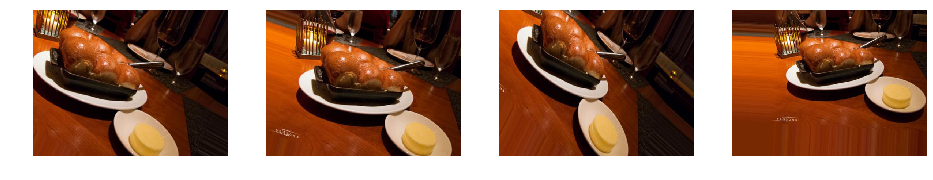

In [103]:
fig = plt.figure(figsize=(16,16))
image1 = plt.subplot(141)
image2 = plt.subplot(142)
image3 = plt.subplot(143)
image4 = plt.subplot(144)
_ = image1.imshow(DApics[0])
_ = image2.imshow(DApics[1])
_ = image3.imshow(DApics[2])
_ = image4.imshow(DApics[3])
image1.axis("off")
image2.axis("off")
image3.axis("off")
image4.axis("off")
plt.show()

As we can see, the images clearly originate from the same photo, but are characterized by a variety of length and width shifts, flips, and stretches. We can now increase the amount of relevant information that the network will use to classify these images.

### 4.3 LeNet

In order to perform the image classification, we use a class of convolutional neural networks called **LeNet**. This architecture of CNNs is relatively small and simple. LeNet is not as resource- and memory-intensive as other networks, and is an appropriate first step in building deep neural networks.

To build this model, we use four different kinds of layers:
* **Conv2D** (Convolutional layer): Applies specified number of convolution filters to the image; moves around the image, subregion by subregion, performing a mathematical operation to produce a single value for that subregion in the output (like dot-product).
* **Activation**: How each artificial neuron changes its internal state after receiving input, providing a smooth transition as input values change. We first use the rectifier activation function, which basically changes all negative values to 0. The final activation function used is the softmax function which takes in a vector of real numbers and normalizes it into a probability distribution.
* **MaxPooling2D**: Applies a filter of size 2x2 and strides of same length to the input volume and outputs the maximum number in every subregion that the filter convolves around.
* **Flatten**: Flattens features into a single column.
* **Dense**: Performs a linear operation in which every input is connected to every output by a weight (fully-connected).

As we can see, the entire network is basically a amalgamation of several functions aiming to optimize the relationship between the input and output.

In [55]:
def build(height, width, depth):
    # height, width, and depth are the pixels and channels of the image
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
        
    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))
 
    # softmax classifier
    model.add(Dense(2))
    model.add(Activation("softmax"))
 
    # return the constructed network architecture
    return model

Now that we have a function which builds the network for us, we initialize some parameters and variables for training and assembling the data.

In [57]:
# initialize training parameters
epochs = 25 # number of times network runs through data
init_learn_rate = 1e-3 # speed at which the network learns the problem
batch_size = 32 # number of samples propagated through the network
 
# define the image and label lists
images = []
labels = []
 
# pull the image paths and randomly shuffle them
imgPaths = sorted(list(imutils.paths.list_images('projdata/train')))
random.seed(111)
random.shuffle(imgPaths)

In the following loop, we read in the image, resize it to 28 x 28 pixels, and create its category label of either *food* or *outside* based on its path name.

In [58]:
# looping over the input images
for imgPath in imgPaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imgPath)
    image = cv2.resize(image, (28, 28)) # every image is 28x28 pixels
    image = img_to_array(image) # turn image into numeric array
    images.append(image)
    # create labels from pathname, add to list
    label = imgPath.split(os.path.sep)[-2]
    label = 1 if label == "food" else 0
    labels.append(label)

Next, we preprocess the images by rescaling the raw pixel intensities from the [0, 255] range to the [0, 1] range. We proceed to randomly split the data into a training and testing set so that the network can use cross-validation to evaluate its performance while it trains and learns. This prevents overfitting and ensures that the model is always seeing new images and minimizing its cost.

In [59]:
# scale the pixel intensities from [0,255] to the range [0, 1]
data = np.array(images, dtype="float") / 255.0
labels = np.array(labels)
 
# split data in 25% testing and 75% training
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
                                                  test_size=0.25, random_state=111)
 
# convert the labels from integers to one-hot-encoded vectors
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

We define a data generator as we did in the previous section so that the network can use many more images while training.

In [60]:
# build data augmentor for training, improve robustness
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.2,horizontal_flip=True, fill_mode="nearest")

After all of the preprocessing and preparation, it is now time to build and train the network. We start by defining an Adam optimizer, an extension to stochastic gradient descent. The loss function we use is binary crossentropy which measures the performance of a classification model whose output is a probability value between 0 and 1.

In [61]:
# initialize model
model = build(height = 28, width = 28, depth = 3)
opt = Adam(lr = init_learn_rate, decay = init_learn_rate / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])
 
# train network
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX, testY),
                        steps_per_epoch=len(trainX) // batch_size, 
                        epochs=epochs, 
                        verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
50/50 [==============================] - 6s 126ms/step - loss: 0.5334 - acc: 0.7475 - val_loss: 0.4593 - val_acc: 0.7919
Epoch 2/25
50/50 [==============================] - 4s 88ms/step - loss: 0.3558 - acc: 0.8477 - val_loss: 0.2487 - val_acc: 0.9042
Epoch 3/25
50/50 [==============================] - 4s 82ms/step - loss: 0.2951 - acc: 0.8748 - val_loss: 0.2301 - val_acc: 0.9079
Epoch 4/25
50/50 [==============================] - 4s 83ms/step - loss: 0.3104 - acc: 0.8777 - val_loss: 0.2209 - val_acc: 0.9227
Epoch 5/25
50/50 [==============================] - 4s 86ms/step - loss: 0.2835 - acc: 0.8823 - val_loss: 0.2489 - val_acc: 0.9061
Epoch 6/25
50/50 [==============================] - 5s 91ms/step - loss: 0.2712 - acc: 0.8873 - val_loss: 0.2121 - val_acc: 0.9153
Epoch 7/25
50/50 [==============================] - 4s 86ms/step - loss: 0.2641 - acc: 0.8856

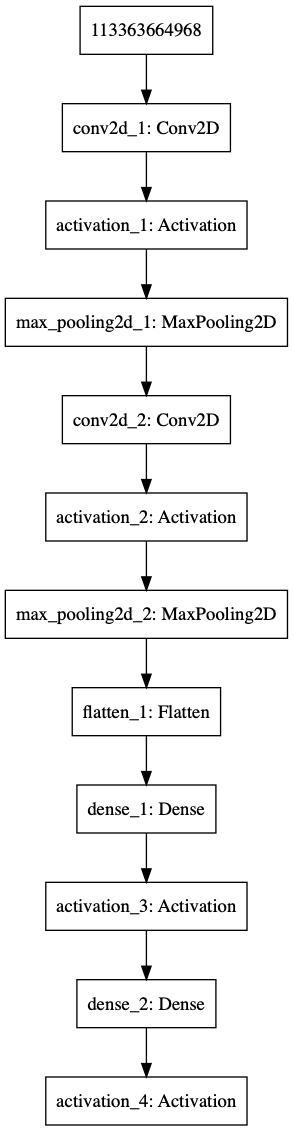

In [62]:
plot_model(model, to_file='layers.png')
layer_plot = Image.open('layers.png')
layer_plot

The network is quite efficient and trains rather quickly; it takes only 11 epochs through the data to achieve a validation accuracy of 90%, an impressive metric. This high score tells us that we have succeeded in building an effective network.

We plot the loss and accuracy of the model training process.

<Figure size 432x288 with 0 Axes>

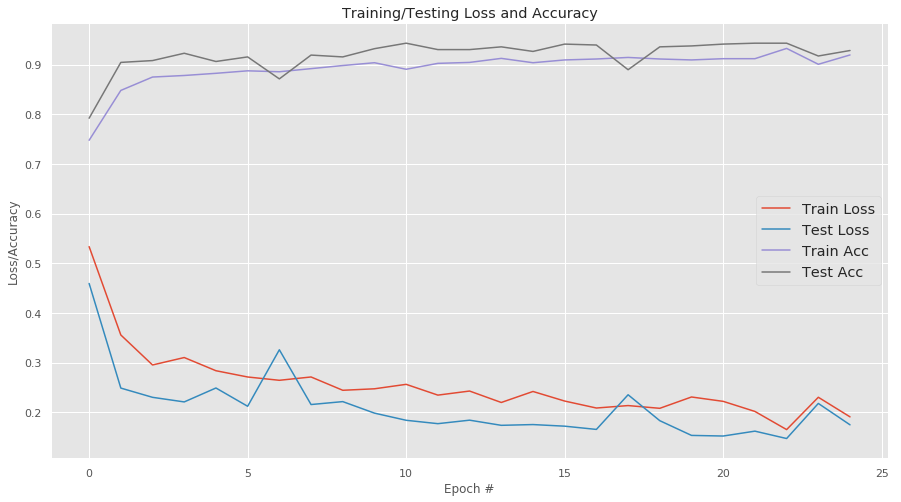

In [63]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.figure(figsize=(15,8))
plt.plot(np.arange(0, N), H.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="Test Loss")
plt.plot(np.arange(0, N), H.history["acc"], label="Train Acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="Test Acc")
plt.title("Training/Testing Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="right",fontsize='x-large')
plt.show()

As we can see, over each epoch both the training and testing losses decrease to around 0.25, while the accuracies increase to 90%.

### 4.5 Evaluation

We can now see for ourselves how acccurate the model is with some test predictions and visualizations. To run our predictions through the model, we have to load in the test images, resize and rescale them, use the model to make predictions, create the labels based on the predictions, then format our output images.

In [64]:
# load some images
test_img1 = 'projdata/test/food/v3Egaj0EuvVjDJomXSuQEg.jpg'
test_img2 = 'projdata/test/food/cXkz5Yx46bMsudTi7n9qXA.jpg'
test_img3 = 'projdata/test/outside/ycSVGgayYvm9GRhHBpG2jw.jpg'
test_img4 = 'projdata/test/outside/r6oOljrNerQ9RLVpyQgkGg.jpg'
test_paths = [test_img1, test_img2, test_img3, test_img4]
outs = []
for path in test_paths:
    # load image
    image = cv2.imread(path)
    orig = image.copy()

    # pre-process the image for classification
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    
    # classify the input image
    (outside, food) = model.predict(image)[0]
    
    # build the label
    label = "Food" if food > outside else "Outside"
    proba = food if food > outside else outside
    label = "{}: {:.2f}%".format(label, proba * 100)

    # draw the label on the image
    output = imutils.resize(orig, width=400)
    cv2.putText(output, label, (10, 25),  
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    output=cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    outs.append(Image.fromarray(output))

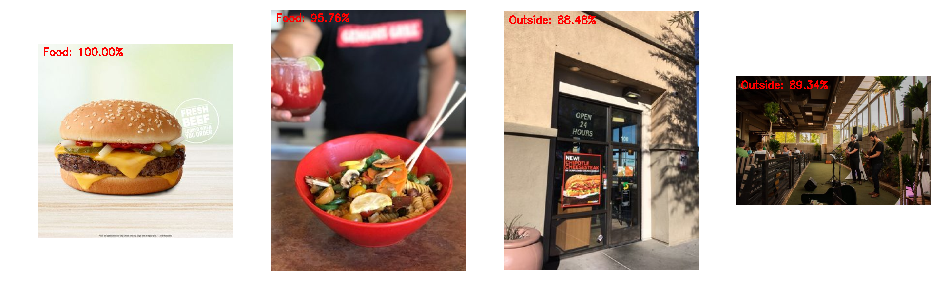

In [65]:
fig = plt.figure(figsize=(16,16))
image1 = plt.subplot(141)
image2 = plt.subplot(142)
image3 = plt.subplot(143)
image4 = plt.subplot(144)
_ = image1.imshow(outs[0])
_ = image2.imshow(outs[1])
_ = image3.imshow(outs[2])
_ = image4.imshow(outs[3])
image1.axis("off")
image2.axis("off")
image3.axis("off")
image4.axis("off")
plt.show()

As we can see, the network correctly predicts the nature of most of the images with confidence. The second image from the left was only predicted correctly with a probability of about 72%; this could likely be due to the other distracting parts of the image, like the man in the background and the drink held close to the camera. Besides this, the network is still impressively able to correctly classify the subject of each image.

## 5 Conclusion

## 6 References

* *Yelp Open Dataset* by Yelp, https://www.yelp.com/dataset
* *LeNet – Convolutional Neural Network in Python* by Adrian Rosebrock, https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/
* *Image classification with Keras and deep learning* by Adrian Rosebrock, https://www.pyimagesearch.com/2017/12/11/image-classification-with-keras-and-deep-learning/
* *Building powerful image classification models using very little data* by Francois Chollet, https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
* *Gentle Introduction to the Adam Optimization Algorithm for Deep Learning* by Jason Brownlee, https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/